# Dynamical System: Lorenz-96 


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import xarray as xr
import numpy as np

from jaxsw._src.models.lorenz96 import L96State, Lorenz96, rhs_lorenz_96

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 96


* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\frac{dx}{dt} = (x_{i+1} - x_{i-2})x_{i-1}-x_i+F
$$

where $F$ is normally 8 to cause some chaotic behaviour.

In [2]:
F = 8

In [3]:
# initialize state
ndim = 50
noise = 0.01
state, params = L96State.init_state(ndim=ndim, noise=noise, F=8)

# rhs
x = state.x
state_dot = rhs_lorenz_96(x=x, F=F)

x_dot = state_dot

assert x_dot.shape == x.shape

### Model

In [4]:
t0 = 0.0
t1 = 30.0

# initialize state
state_init, params = L96State.init_state(ndim=ndim, F=F)

# initialize model
l96_model = Lorenz96()

# step through
state_dot = l96_model.equation_of_motion(t=0, state=state_init, args=params)

state_dot.x.shape

(50,)

## Time Stepping

In [5]:
dt = 0.01
t0 = 0.0
t1 = 30.0

ts = jnp.arange(t0, t1, dt)

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=ts)
saveat

SaveAt(
  subs=SubSaveAt(
    t0=0.0,
    t1=30.0,
    ts=f32[3000],
    steps=False,
    fn=<function save_y>
  ),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [6]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l96_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [7]:
sol.ys.x.shape

(3001, 50)

In [8]:
da_sol = xr.DataArray(
    data=np.asarray(sol.ys.x),
    dims=["time", "dimension"],
    coords={
        "dimension": (["dimension"], np.arange(0, len(sol.ys.x[0]))),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={
        "ode": "lorenz_96",
        "F": params.F,
    },
)

da_sol

<xarray.DataArray (time: 3001, dimension: 50)>
array([[ 7.9924693 ,  8.        ,  8.        , ...,  8.        ,
         8.        ,  8.        ],
       [ 7.9925447 ,  8.        ,  8.000603  , ...,  8.        ,
         8.        ,  7.9993978 ],
       [ 7.992619  ,  8.000096  ,  8.001193  , ...,  8.        ,
         7.999952  ,  7.9988074 ],
       ...,
       [-3.0757656 ,  1.1461757 ,  0.24342385, ..., -0.9191787 ,
         1.0743638 ,  7.292257  ],
       [-2.9597716 ,  1.4315319 ,  0.35043436, ..., -0.5976648 ,
         1.030199  ,  7.276175  ],
       [-2.9597716 ,  1.4315319 ,  0.35043436, ..., -0.5976648 ,
         1.030199  ,  7.276175  ]], dtype=float32)
Coordinates:
  * dimension  (dimension) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time       (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Attributes:
    ode:      lorenz_96
    F:        8

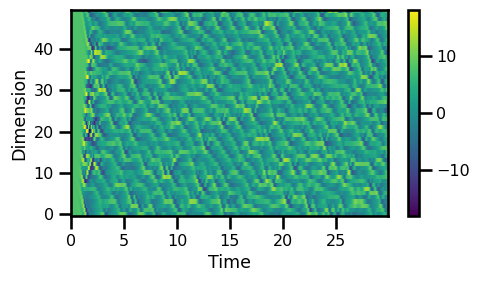

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

da_sol.T.plot.imshow(cmap="viridis")

ax.set_xlabel("Time")
ax.set_ylabel("Dimension")

plt.tight_layout()
plt.show()

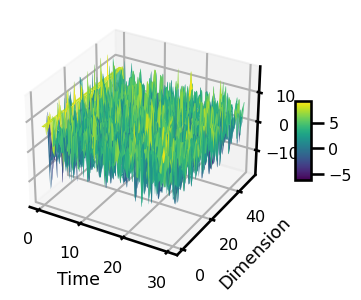

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={"projection": "3d"})

pts = da_sol.T.plot.surface(ax=ax, add_colorbar=False, cmap="viridis")

cbar_kwargs = dict(shrink=0.3, aspect=5, cmap="viridis")
plt.colorbar(pts, **cbar_kwargs)

ax.set_xlabel("Time")
ax.set_ylabel("Dimension")

plt.tight_layout()
plt.show()

## Batch of Trajectories

In [11]:
batchsize = 100

state_batch, params = L96State.init_state_batch(ndim=ndim, batchsize=batchsize, F=F)

fn_batched = jax.vmap(rhs_lorenz_96, in_axes=(0, None))

state_dot_batch = fn_batched(state_batch.x, F)
x_dot = state_dot_batch
# state_dot_batch = fn_batched(state_batch)

assert x_dot.shape == state_batch.x.shape
assert state_batch.x.shape == x_dot.shape

In [12]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
integrate = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l96_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)
sol = jax.vmap(integrate)(state_batch)

In [13]:
da_sol = xr.DataArray(
    data=sol.ys.x,
    dims=["realization", "time", "dimension"],
    coords={
        "realization": (["realization"], np.arange(0, len(sol.ys.x))),
        "dimension": (["dimension"], np.arange(0, len(sol.ys.x[0].T))),
        "time": (["time"], np.asarray(sol.ts[0])),
    },
    attrs={
        "ode": "lorenz_96",
        "F": params.F,
    },
)

da_sol

<xarray.DataArray (realization: 100, time: 3001, dimension: 50)>
array([[[ 8.000911  ,  8.        ,  8.        , ...,  8.        ,
          8.        ,  8.        ],
        [ 8.000901  ,  8.        ,  7.999927  , ...,  8.        ,
          8.        ,  8.0000725 ],
        [ 8.000893  ,  7.9999886 ,  7.9998555 , ...,  8.        ,
          8.000006  ,  8.000144  ],
        ...,
        [ 1.5364083 ,  3.3949282 ,  9.818625  , ..., -1.7159522 ,
          1.491345  ,  5.3097    ],
        [ 1.7021288 ,  3.5102332 ,  9.612237  , ..., -1.6190811 ,
          1.4634391 ,  5.385108  ],
        [ 1.7021288 ,  3.5102332 ,  9.612237  , ..., -1.6190811 ,
          1.4634391 ,  5.385108  ]],

       [[ 7.9915767 ,  8.        ,  8.        , ...,  8.        ,
          8.        ,  8.        ],
        [ 7.991661  ,  8.        ,  8.000674  , ...,  8.        ,
          8.        ,  7.999326  ],
        [ 7.9917445 ,  8.000108  ,  8.001334  , ...,  8.        ,
          7.999946  ,  7.998666  ],
...
        [ 0.23525652, -7.3189664 ,  2.0322928 , ...,  4.0873923 ,
         10.932283  ,  2.3696332 ],
        [-0.11958751, -7.1667247 ,  2.3185236 , ...,  3.9108768 ,
         11.077332  ,  2.0047805 ],
        [-0.11958751, -7.1667247 ,  2.3185236 , ...,  3.9108768 ,
         11.077332  ,  2.0047805 ]],

       [[ 7.9984074 ,  8.        ,  8.        , ...,  8.        ,
          8.        ,  8.        ],
        [ 7.998423  ,  8.        ,  8.000128  , ...,  8.        ,
          8.        ,  7.9998727 ],
        [ 7.998439  ,  8.00002   ,  8.000253  , ...,  8.        ,
          7.99999   ,  7.9997478 ],
        ...,
        [ 3.9305358 ,  7.957988  ,  3.8447258 , ..., -1.2128105 ,
          6.7456527 ,  2.8945193 ],
        [ 4.0063386 ,  7.9957504 ,  4.0669274 , ..., -1.1180475 ,
          6.723343  ,  3.292535  ],
        [ 4.0063386 ,  7.9957504 ,  4.0669274 , ..., -1.1180475 ,
          6.723343  ,  3.292535  ]]], dtype=float32)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * dimension    (dimension) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time         (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Attributes:
    ode:      lorenz_96
    F:        8

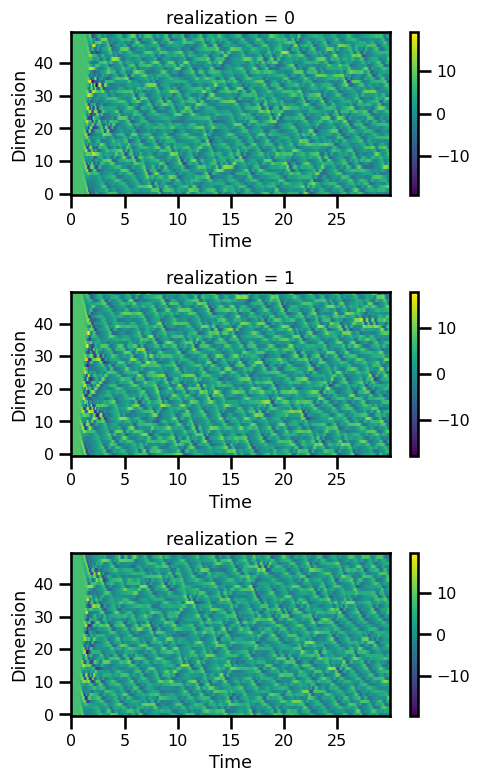

In [14]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for i in range(3):
    da_sol.isel(realization=i).T.plot.imshow(ax=ax[i], cmap="viridis")

    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Dimension")

plt.tight_layout()
plt.show()